<a href="https://colab.research.google.com/github/WannaBreakout/W4_Pneumonia_Detection/blob/master/W4_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# W4 Pneumonia

Training a classifier on medical images is a crucial task to aid doctors and provide lower cost services to patients. If we can build a classifier that can diagnosis a given disease and provide it to patients who can't afford a doctor as an app, we have a scalable business. In this homework, we're going to perform transfer learning to predict pneumonia in a patient, given their chest x-ray data.

## Instructions:

Retrain the 'inception v3' image classifier on the pneumonia dataset using Tensorflow+Keras. Create a jupyter notebook of your script and be sure to show the training process as well as 2 examples of it making predictions on images from the testing dataset. This link will give you an idea of how it can be done. 

## Resource / Reference

**remove .DS_Store files - they break things
```
os.remove('./chest_xray/val/.DS_Store')
os.remove('./chest_xray/test/.DS_Store')
os.remove('./chest_xray/train/.DS_Store')
```

### Dexter1618 - thank you

```
!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/41d542e7-7f91-47f6-9ff2-dd8e5a5a7861/ChestXRay2017.zip

from zipfile import ZipFile
with ZipFile("./ChestXRay2017.zip", "r") as f:
    f.extractall(path = "./")

train_files = "./chest_xray/train/"
test_files = "./chest_xray/test/"

```

### vyasmm
      https://github.com/vyasmm/Pneumonia-Detection



### Anjana Tiha

```
Author           : Anjana Tiha
Project Name     : Detection of Pneumonia from Chest X-Ray Images using Convolutional Neural Network, 
                   and Transfer Learning.
Description      : 1. Detected Pneumonia from Chest X-Ray images using Custom Deep Convololutional Neural Network and by retraining pretrained model “InceptionV3” with 5856 images of X-ray (1.15GB).
                 
Tools/Library    : Python, Keras, PyTorch, TensorFlow
Version History  : 1.0.0.0
Current Version  : 1.0.0.3
Last Update      : 12.16.2018

```

### @Stefan999 's suggestion :
```
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(51024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='sigmoid')(x)
model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)
```

## Import Data

In [0]:
!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/41d542e7-7f91-47f6-9ff2-dd8e5a5a7861/ChestXRay2017.zip
 
from zipfile import ZipFile
with ZipFile("./ChestXRay2017.zip", "r") as f:
    f.extractall(path = "./")
 
train_files = "./chest_xray/train/"
test_files = "./chest_xray/test/"

In [45]:
%ls chest_xray/train/

NORMAL/  PNEUMONIA/


** OR we need to pull the data directly from Kaggle using API
```
os.environ['KAGGLE_USERNAME'] = "XXXXXX" # username from the json file 
os.environ['KAGGLE_KEY'] = "YYYYYYYYYYYYYYY" # key from the json file
!kaggle datasets download paultimothymooney/chest-xray-pneumonia # api copied from kaggle
!unzip /content/chest-xray-pneumonia.zip
!unzip /content/chest_xray.zip
```

In [77]:
# Lets first install tensorflow 2.0.0.rc1
!pip install tensorflow-gpu==2.0.0.rc1

     |████████████████████████████████| 380.5MB 69kB/s 
     |████████████████████████████████| 501kB 47.1MB/s 
     |████████████████████████████████| 4.3MB 44.7MB/s 


In [0]:

# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = "chest_xray"
output_directory = "models"



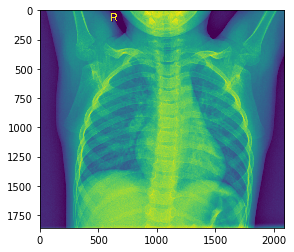

In [88]:

# Now let's define the path to our train, validation and test directories
dataset_path = "./chest_xray/"

# We have 3 datasets: train, validation and test

training_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
testing_dir = os.path.join(dataset_path, "test")

# Let's visualize some an example in the training set
example_img = mpimg.imread(training_dir + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)

## OnTo Training

In [1]:
import sys
import os
import argparse
import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
import cv2

import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense

from keras.applications.inception_v3 import InceptionV3
from keras import backend as K

from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import class_weight


from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf



from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

Using TensorFlow backend.


In [0]:
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

In [0]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
  
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}

    plot_params["figsize"] = figsize

    plot_params["title"] = title

    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel

    plot_params["legends"] = legends 

    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize

    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image

    plot_params["subplot"] = None
    return plot_params

def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)
    image_file_paths = {}
    for i in range(class_count):
        subdir_path = os.path.join(image_dir, classes[i])
        subdir_files = os.listdir(subdir_path)
        sampled_files = random.sample(subdir_files, image_count_per_category)
        for j in range(len(sampled_files)):
            full_path = os.path.join(image_dir, classes[i], sampled_files[j])
            sampled_files[j] = full_path
        image_file_paths[classes[i]] = sampled_files

    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])

    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])

        i=i+1

    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])

    plt.tight_layout()
    plt.show()

    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)

In [0]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)

    return subdirectory_names, subdirectory_file_counts

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [0]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    tf.reset_default_graph()   
    K.clear_session()
    gc.collect()
    return True

# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

In [15]:
reset_graph()
reset_callbacks()

In [118]:
import os,shutil
print('total training NORMAL images:', len(os.listdir(training_dir+'/NORMAL')))
print('total testing NORMAL images:', len(os.listdir(testing_dir+'/NORMAL')))
print('total validation NORMAL images:', len(os.listdir(validation_dir+'/NORMAL')))

total training NORMAL images: 1342
total testing NORMAL images: 234
total validation NORMAL images: 9


In [0]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [38]:
from pathlib import Path

train_files = "./chest_xray/train/"
test_files = "./chest_xray/test/"
validation_files = "./chest_xray/val/"

positive_class_folder_name = "PNEUMONIA"
negative_class_folder_name = "NORMAL"
# training files

# number of X-RAYS which show Pneumonia
P = Path(train_files + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = Path(train_files + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Normal - %i " % len(temp))



Training-Pneumonia - 3875 
Training-Normal - 1341 


In [42]:
# testing files

# number of X-RAYS which show Pneumonia
P = Path(test_files + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(test_files + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Normal - %i " % len(temp))

Testing-Pneumonia - 390 
Testing-Normal - 234 


In [0]:
#-----------------------------------
# GLOBAL FEATURE EXTRACTION
#-----------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2
import os
import h5py

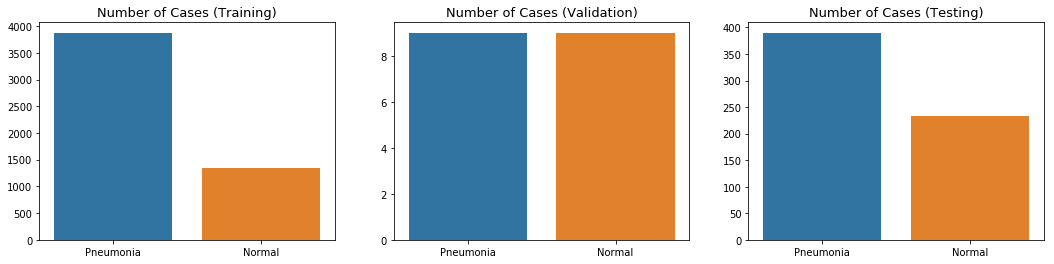

In [103]:
plot_params = get_reset_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = "Number of Cases"

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]

### Reading data using TF ImageDataGenerator

In [104]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = "categorical"
#class_mode = "binary"

train_datagen = ImageDataGenerator(
  rescale=rescale,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
  training_dir,
  target_size=target_size,
  class_mode=class_mode,
  batch_size=50,
  shuffle=True)

validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  target_size=target_size,
  class_mode=class_mode,
  batch_size=2,
  shuffle = False)

test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
  testing_dir,
  target_size=target_size,
  class_mode=class_mode,
  batch_size=20,
  shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [0]:
class_weight = get_weight(train_generator.classes)
class_weight

### Callbacks

In [0]:
main_model_dir = os.path.join(output_directory, "models")
main_log_dir = os.path.join(output_directory, "logs")
model_file = main_model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

checkpoint = ModelCheckpoint(
  model_file, 
  monitor='val_acc', 
  save_best_only=False)

early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=5,
  verbose=1,
  restore_best_weights=True)

tensorboard = TensorBoard(
  log_dir=main_log_dir,
  batch_size=batch_size,
  update_freq = 'batch')

reduce_lr = ReduceLROnPlateau(
  monitor='val_loss',
  patience=5,
  cooldown=2,
  min_lr=0.0000000001,
  verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]

### Custom Model

In [0]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(150,150,3)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    #model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    #model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    #model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    #model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 , activation='softmax'))

    return model

In [70]:
model = get_conv_model()
model.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                5760064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__

In [71]:
steps_per_epoch=105
validation_steps=8

optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 10

model.compile(optimizer, loss=loss, metrics=metrics)

In [72]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = steps_per_epoch,
  epochs=epochs,
  verbose=1,
  callbacks=callbacks,
  validation_data=validation_generator,
  validation_steps=validation_steps, 
  class_weight=class_weight)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
105/105 [==============================] - 66s 626ms/step - loss: 4.1651 - acc: 0.7396 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/10
105/105 [==============================] - 63s 605ms/step - loss: 4.1496 - acc: 0.7426 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/10
105/105 [==============================] - 64s 605ms/step - loss: 4.1302 - acc: 0.7438 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/10
105/105 [==============================] - 64s 606ms/step - loss: 4.1302 - acc: 0.7438 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/10
105/105 [==============================] - 64s 609ms/step - loss: 4.1367 - acc: 0.7434 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/10
105/105 [==============================] - 64s 606ms/step - loss: 4.1496 - acc: 0.7426 - val_loss: 8.0590 - val_acc: 0.5000

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Restoring mo

# Inception V3 - Transfer Learning

In [0]:
def get_inception_model():    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    x = base_model.output
    # x = Dropout(0.5)(x)
    # x = GlobalAveragePooling2D()(x)
    # x = Dense(512, activation='relu')(x)
    # x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    # predictions = Dense(2, activation='sigmoid')(x) 
    predictions = Dense(2, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False    
    #     for layer in model.layers[:249]:
    #         layer.trainable = False
    #     for layer in model.layers[249:]:
    #         layer.trainable = True

    return model

In [74]:
inception_model = get_inception_model()
inception_model.summary()



87916544/87910968 [==============================] - 7s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
_________________________

In [0]:
steps_per_epoch=105
validation_steps=8

optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 100

inception_model.compile(optimizer, loss=loss, metrics=metrics)

In [76]:
history = inception_model.fit_generator(
  train_generator,
  steps_per_epoch = steps_per_epoch,
  epochs=epochs,
  verbose=1,
  callbacks=callbacks,
  validation_data=validation_generator,
  validation_steps=validation_steps)

Epoch 1/100
105/105 [==============================] - 68s 650ms/step - loss: 0.4288 - acc: 0.8835 - val_loss: 5.0533 - val_acc: 0.5000
Epoch 2/100
105/105 [==============================] - 59s 564ms/step - loss: 0.3929 - acc: 0.9036 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/100
105/105 [==============================] - 65s 617ms/step - loss: 0.4195 - acc: 0.9089 - val_loss: 3.9702 - val_acc: 0.5625
Epoch 4/100
105/105 [==============================] - 65s 618ms/step - loss: 0.4387 - acc: 0.9079 - val_loss: 2.8750 - val_acc: 0.5625
Epoch 5/100
105/105 [==============================] - 65s 620ms/step - loss: 0.3704 - acc: 0.9242 - val_loss: 3.5287 - val_acc: 0.6875
Epoch 6/100
105/105 [==============================] - 65s 621ms/step - loss: 0.4220 - acc: 0.9185 - val_loss: 6.6082 - val_acc: 0.5000
Epoch 7/100
105/105 [==============================] - 66s 625ms/step - loss: 0.4363 - acc: 0.9156 - val_loss: 7.9462 - val_acc: 0.5000
Epoch 8/100
105/105 [===========================

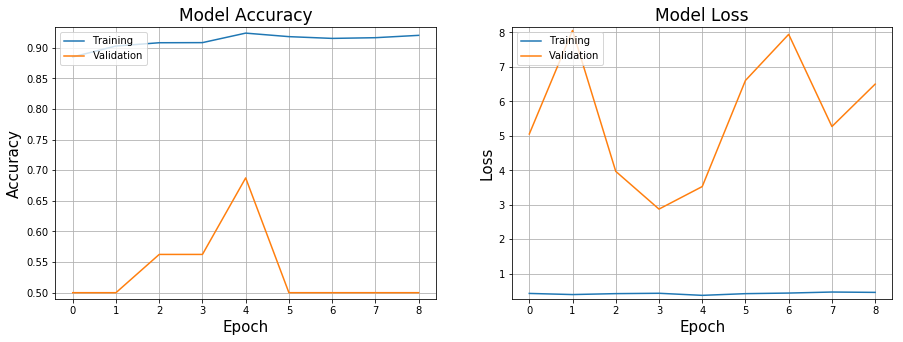

In [107]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

### Result

In [108]:
result  = inception_model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

32/32 [==============================] - 7s 211ms/step
Loss     : 2.57  
Accuracy : 69.71%


Seems like we need more validation data to improve performance!<br>
For now, let's use the custom model to make predictions.

In [109]:
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

32/32 [==============================] - 5s 163ms/step


In [0]:
precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred)
CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,10), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix")

### Report

In [111]:
cls_report = classification_report(y_true, y_pred, target_names=classes)
print(cls_report)

              precision    recall  f1-score   support

   Pneumonia       0.00      0.00      0.00       234
      Normal       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [112]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 15
-----------------------------------
Batch Size              : 20
-----------------------------------
Accuracy                : 62.50%
-----------------------------------


In [0]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"/"+ file_names[num], 1)
        plt.imshow(img)

        plt.xticks([])
        plt.yticks([])
        
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
    print("Prediction Plot")
    plt.tight_layout()
    plt.show()

In [0]:
batch_size_t = len(y_true_batch)
class_map = {v: k for k, v in test_generator.class_indices.items()}
dpi=100
ncols = 5
nrows = 4
count = ncols*nrows
subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

### Predictions

Prediction Plot


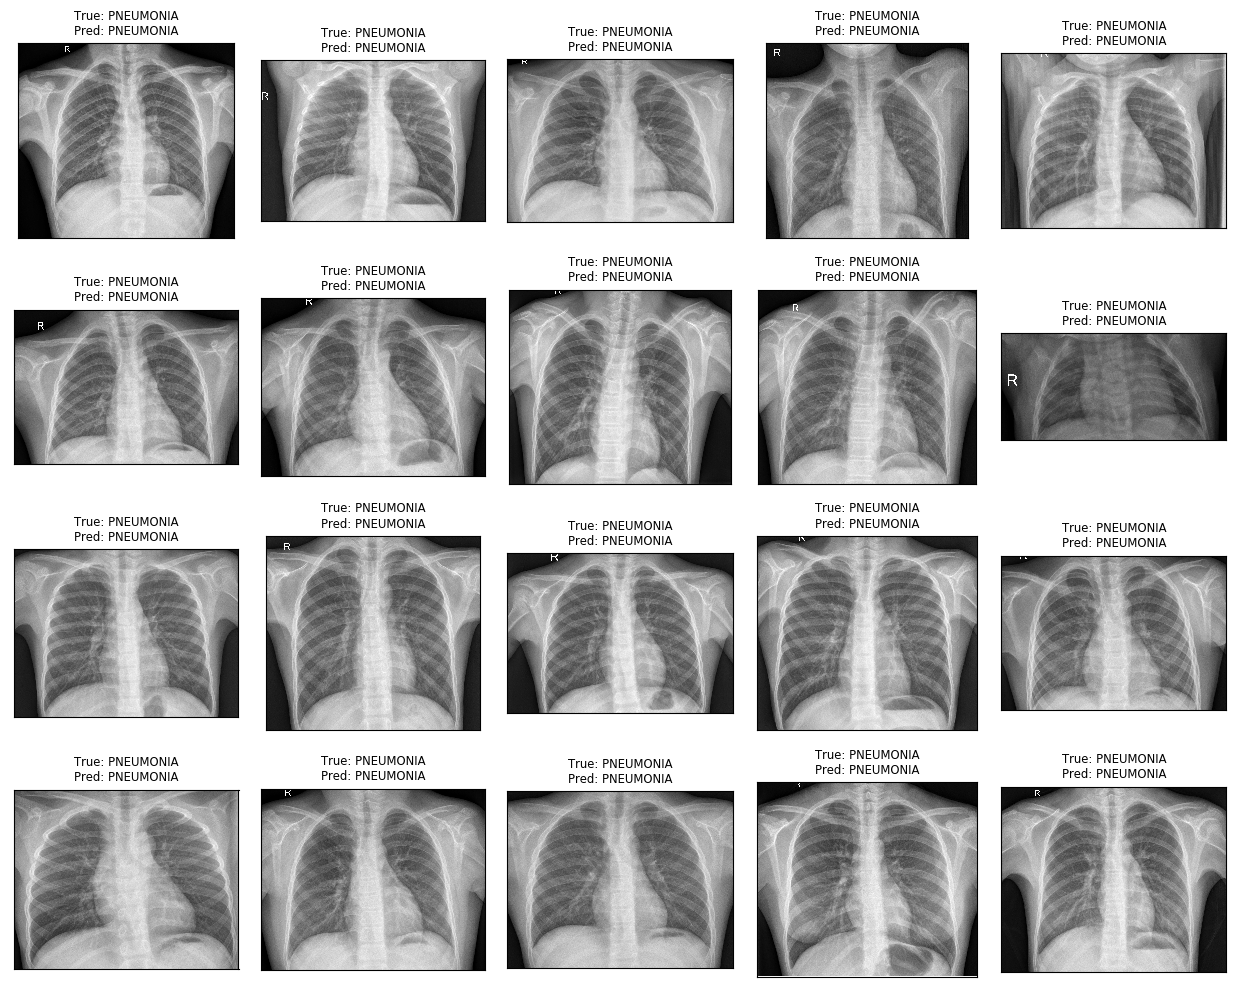

In [115]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, count=count, sample=True)

In [0]:
# Let's visualize some an example in the training set
example_img = mpimg.imread(training_dir + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)